In [1]:
# Set notebook to use only one GPU
%env CUDA_VISIBLE_DEVICES=1     

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from result_analysis_functions import *

Using TensorFlow backend


Keras Uncertainty will use standalone Keras backend

# Results Analysis

Analyse results


# Accuracy and average uncertainty:
Data shape of preds and lockbox: (9, 50, 576, 4), 50 forward passes. 

'''
preds and lockbox shape: (9, 50, 576, 4).
Axis -3 (50) should be collapsed only in the 
following cases:
    - accuracy
    - std. dev.
Collapsing of the axis for uncertainty is in
models_bachelors.py
'''

### Accuracy of each method

In [ ]:
acc_mcdropconnect = {'test': [], 'lockbox': []}
acc_mcdropout = {'test': [], 'lockbox': []}
# acc_std = {'test': [], 'lockbox': []}
# acc_std_mcdropconnect = {'test': [], 'lockbox': []}
NUM = 50  # Number of prediction sets
# Load each prediction set and compute avg accuracy for each set, adding them to list
for n in range(NUM):
    methods = load_dict_from_hdf5(f'predictions/predictions_{n}.h5')
    for name, method in methods.items():
        isStandard = True if 'standard' in name else False
        # print(f'y_true: {method["test"]["labels"].argmax(axis=-1).shape}, y_pred: {method["test"]["preds"].argmax(axis=-1).shape}')
        test_accs = get_accuracies(method["test"], isStandard)   # Get test set accuracies
        lock_accs = get_accuracies(method["lockbox"], isStandard)
        if name == 'mcdropconnect':
            acc_mcdropconnect['test'].append(test_accs)
            acc_mcdropconnect['lockbox'].append(lock_accs)
        elif name == 'mcdropout':
            acc_mcdropout['test'].append(test_accs)
            acc_mcdropout['lockbox'].append(lock_accs)
        elif name == 'standard':
            acc_std['test'].append(test_accs)
            acc_std['lockbox'].append(lock_accs)
        else:
            acc_std_mcdropconnect['test'].append(test_accs)
            acc_std_mcdropconnect['lockbox'].append(lock_accs)

# Only for UQ:
for name, key in acc_mcdropconnect.items():
    key = np.array(key).mean(axis=0)

for name, key in acc_mcdropout.items():
    key = np.array(key).mean(axis=0)



In [ ]:
from numpy import round

r = 5
# print(round(np.std(acc_mcdropconnect["test"]), 5))
print('mcdropout')
# print(acc_mcdropout)
# print(f'test set avg acc: {round(np.mean(acc_mcdropout["test"]), r) * 100} +/- {round(np.std(acc_mcdropout["test"]), r) * 100}')
# print(f'lockbox set avg acc: {round(np.mean(acc_mcdropout["lockbox"]), r) * 100} +/- {round(np.std(acc_mcdropout["lockbox"]), r) * 100}\n')

# print('mcdropconnect')
# print(f'test set avg acc: {round(np.mean(acc_mcdropconnect["test"]), r) * 100} +/- {round(np.std(acc_mcdropconnect["test"]), r) * 100}')
# print(f'lockbox set avg acc: {round(np.mean(acc_mcdropconnect["lockbox"]), r) * 100} +/- {round(np.std(acc_mcdropconnect["lockbox"]), r) * 100}\n')

print('standard_dropout')
print(f'test set avg acc: {round(np.mean(acc_std["test"]), r) * 100} +/- {round(np.std(acc_std["test"]), r) * 100}')
print(f'lockbox set avg acc: {round(np.mean(acc_std["lockbox"]), r) * 100} +/- {round(np.std(acc_std["lockbox"]), r) * 100}\n')


print('standard_dropconnect')
print(f'test set avg acc: {round(np.mean(acc_std_mcdropconnect["test"]), r) * 100} +/- {round(np.std(acc_std_mcdropconnect["test"]), r) * 100}')
print(f'lockbox set avg acc: {round(np.mean(acc_std_mcdropconnect["lockbox"]), r) * 100} +/- {round(np.std(acc_std_mcdropconnect["lockbox"]), r) * 100}\n')

### Average normalised predictive entropy

And associated normalised intersection for comparison [0, 1]


In [ ]:
def avg_pred_entropy_plots(dataset, method, unc_method):
    bin_size = 0.05
    entropy_correct = []
    entropy_wrong = []
    # For data loading standard predictions are in a single file
    if 'standard' in method:
        N = 1
        isStandard = True
    else:
        N = 50
        isStandard = False

    # Iterate over all prediction sets.
    if not isStandard:
        for n in range(N):
            methods = load_predictions(n, isStandard)
            data = methods[method][dataset]
            entropy = get_uncertainty(data,unc_method)
            Y_true = data['labels']    # shape: (9,576,4)
            corrects = get_corrects(Y_true, data['preds'], axis=-1) # Get corrects across ALL subjects
            # Append the nth prediction's uncertainty estimations
            entropy_correct.append(entropy[corrects])
            entropy_wrong.append(entropy[~corrects])
            # For distribution plots of predictive entropy
    else:
        methods = load_predictions(0, isStandard)
        data = methods[method][dataset]
        print()
        entropy = get_uncertainty(data, unc_method)
        Y_true = data['labels']    # shape: (9,576,4)
        corrects = get_corrects(Y_true, data['preds'], axis=-1) # Get corrects across ALL subjects
        # Append the nth prediction's uncertainty estimations
        entropy_correct.append(entropy[corrects])
        entropy_wrong.append(entropy[~corrects])

    '''
    Check for data mismatch: entropy_correct is probably a list of np arrays instead of 
    1 cohesive np array 
    '''
    entropy_correct = np.hstack(entropy_correct)
    entropy_wrong = np.hstack(entropy_wrong)
    r = 5
    unc_cor = np.mean(entropy_correct)
    unc_cor_std = np.std(entropy_correct)
    unc_in = np.mean(entropy_wrong)
    unc_in_std = np.std(entropy_wrong)
    print(f"{dataset} avg. {unc_method} correct: {unc_cor:.5f} +/ {unc_cor_std:.5f}")
    print(f"{dataset} avg. {unc_method} wrong: {unc_in:.5f} +/ {unc_in_std:.5f}")

    # hist_data = [entropy_correct, entropy_wrong]    
    # group_labels = ['Correct', 'Incorrect']

    # # Normalizes AREA UNDER CURVE to sum up to 1. y-axis values are meaningless.
    # hist_correct, bins_correct, _ = plt.hist(entropy_correct, bins=20, density=True, alpha=0.5, label='Correct')
    # hist_wrong, bins_wrong, _ = plt.hist(entropy_wrong, bins=20, density=True, alpha=0.5, label='Wrong')
    # plt.legend()
    # # plt.show()

    # # Calculate overlap using histogram intersection
    # overlap = np.sum(np.minimum(hist_correct, hist_wrong))

    # # Normalize overlap between 0 and 1
    # normalized_overlap = overlap / np.sum(hist_correct)

    # print("Overlap:", normalized_overlap)


In [ ]:
methods = ['mcdropconnect', 'mcdropout', 'standard', 'standard_dropconnect']

for method in methods:
    print(f'{method}\n')
    # False makes calculations off of mutual information
    avg_pred_entropy_plots('test', method, 'shannon-entropy')
    avg_pred_entropy_plots('lockbox', method, 'shannon-entropy')
    # avg_pred_entropy_plots('lockbox', method, 'mutual-information')
    # avg_pred_entropy_plots('lockbox', method, 'shannon-entropy')

### PLOT ACC COV ON X AND Y AXIS, NOT THRESHOLD
These plots are to select a threshold for treating uncertainty as a binary classification task. Once the threshold is selected from the plot, you can compute the uncertainty accuracy, precision, sensitivity, specificity ROC plots and AUROC.

So accuracy and coverage will be computed for predictions that are above a certain uncertainty threshold

Explanations for very poor entropy based accuracy-coverage plots:
Because of high inter-subject variability, the specific model is unable to fully learn subject-independent features, leading to a high degree of epistemic uncertainty (my theory). Maybe I can confirm this by disentangling uncertainty... 

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
'''
makes acc cov plot for a single method
isEntropy is a bool to set whether to use entropy threshold
or softmax prob threshold. Key is the dataset name ('test' or 'lockbox').
method is the name of the method.
'''
def make_acc_cov_plot(method, key, isEntropy):
    thresholds = np.arange(0, 1.001, 0.001)
    N = 50
    accs = []
    coverages = []
    y_pred = []
    y_true = []
    for n in range(N):
        methods = load_dict_from_hdf5(f'predictions/predictions_{n}.h5')
        data = methods[method][key]
        y_pred.append(np.vstack(data['preds']))
        y_true.append(np.vstack(data['labels']))

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    if isEntropy:
        unc = predictive_uncertainty(y_pred)
    for t in thresholds:
        if isEntropy:
            accepted_idx = (unc < t)           # Accept samples when uncertainty is BELOW threshold
        else:
            accepted_idx = y_pred.max(axis=1) > t           # Accept when predicted prob is ABOVE threshold
        coverages.append(sum(accepted_idx) / y_pred.shape[0])                           # Coverage: How many samples rejected
        acc = accuracy_score(y_pred=y_pred.argmax(axis=1)[accepted_idx], y_true=y_true.argmax(axis=1)[accepted_idx])  # Accuracy of accepted samples
        accs.append(acc)

    if isEntropy:
        coverages = np.flip(np.array(coverages))  # Flip for entropy threshold
        accs = np.flip(np.array(accs))
    else:
        coverages = np.array(coverages)
        accs = np.array(accs)

    plt.plot(coverages, accs, color='red')

    plt.title('Coverage and Accuracy vs Threshold')
    plt.legend()
    # plt.savefig('threshold_plots.png')
    plt.show()

    # Finding equivalent threshold value
    point = np.hstack(np.argwhere(accs > coverages))
    print(f'threshold value for {method}: {point[0] * 0.001}\n acc at threshold: {accs[point[0]]}\n coverage at threshold: {coverages[point[0]]}')



methods = ['mcdropconnect', 'mcdropout', 'standard']

for method in methods:
    make_acc_cov_plot(method, 'test', True)


# ROC plots

To see if there is a significant difference between the AUROCs of two methods with a certain metric on one set, need to construct and save a MATLAB struct with two elements:

- spsizes: 2 x 1 vector with samples sizes for X and Y, uncertainties and targets
- ratings: K x N matrix. K is uncertainties/targets of each model, it is the row. N is the sum of len(X) and len(Y) and first len(X) elements are uncertainties and last len(Y) elements are targets

Then I gotta save this data as a MATLAB struct while in python somehow

Things I want to compare for test and lockbox:
- MC-Dropout: mutual information and shannon entropy
- MC-DropConenct: mutual information and shannon entropy

So 2 separate files to save, one for test and the other for lockbox

test
predictive-entropy


mcdropconnect
avg AUROC: 0.685978313624939 +/- 0.0
mcdropout
avg AUROC: 0.6767863333190105 +/- 0.0
standard
avg AUROC: 0.6771020649349001 +/- 0.0
standard_dropconnect
avg AUROC: 0.6694781239241852 +/- 0.0
shannon-entropy


KeyboardInterrupt: 

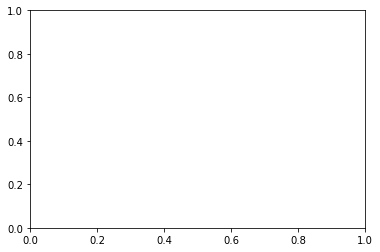

In [4]:
from sklearn.metrics import roc_auc_score, auc
import matplotlib.patches as mpatches
import scipy.stats as stats
from numpy import round

'''
Gets a numpy array down to a 2D array
'''
def get_in_shape(data):
    # If data has shape of 2 elements or less, assume it's already in shape
    if len(data.shape) < 3:
        return data
    else:
        while len(data.shape) > 2:
            data = np.vstack(data)
        return data


'''
data can be whatever shape.
manual roc plot creation reqs:
    y_pred: (9*50, 50, 576, 4)
'''
def make_roc_plot(y_true, y_pred, isStandard, unc_method):
    '''
    y_pred can be either of shape (50, 9, 50, 576, 4) or  (9, 50, 576, 4). We need it in shape (X, 4).
    y_true can be either of shape (50, 9, 576, 4) or (9, 576, 4).
    So apply same algorithm to get these sets into the shape (X, 4)
    '''
    thresholds = np.arange(0, 1.001, 0.001)
    tpr = []
    fpr = []
    unc = get_uncertainty(y_pred, unc_method).flatten()
    y_true = get_in_shape(y_true)
    y_pred = get_in_shape(y_pred) if isStandard else get_in_shape(y_pred.mean(axis=-3))
    
    # print(f'y_true: {y_true.shape}, y_pred: {y_pred.shape}, certains: {unc.shape}')
    for t in thresholds:
        '''
        Order is reversed because FPR and TPR are reversed for some reason
        '''
        certains = (t < unc)           # Certain when uncertainty is below threshold
        uncertains = (t > unc)
        # Calculate TPR and FPR
        tp = sum(y_pred.argmax(axis=1)[uncertains] != y_true.argmax(axis=1)[uncertains])     # N. preds uncertain predictions that are incorrect
        fn = sum(y_pred.argmax(axis=1)[certains] != y_true.argmax(axis=1)[certains])      # Prediction that's certain and incorrect
        fp = sum(y_pred.argmax(axis=1)[uncertains] == y_true.argmax(axis=1)[uncertains])   # prediction that's uncertain and correct
        tn = sum(y_pred.argmax(axis=1)[certains] == y_true.argmax(axis=1)[certains]) # Prediction that's certain and correct
        # print(f'tp: {tp} fn: {fn} fp: {fp} tn: {tn}')
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
    # fig1, ax1 = plt.subplots()
    # hist_correct, bins_correct, _ = ax1.hist(auc, bins=10, density=False, alpha=0.5, label='Correct')
    # fig1.show()
    return np.array(tpr), np.array(fpr)


'''
I calculate AUROC and plot ROC separately because I want to get
mean AUROC of all 50 prediction sets along with their variance.
Then I plot ROC with all 50 prediction sets.
'''
def roc_plot_and_auroc(method, key, unc_method):
    y_pred = []
    y_true = []
    aucs_lst = []
    isStandard = True if 'standard' in method else False
    num_predictions = 50 if not isStandard else 1
    # creation of set of 50 predictions, as well as AUROC score calculation
    for n in range(num_predictions):
        methods = load_predictions(n, isStandard)
        data = methods[method][key]
        tpr, fpr = make_roc_plot(data['labels'], data['preds'], isStandard, unc_method)
        # print(f'y_true shape: {y_true_roc.shape} y_pred: {y_pred_roc.shape}')
        auroc_score = auc(tpr, fpr)
        aucs_lst.append(auroc_score)
        y_pred.append(data['preds'])
        y_true.append(data['labels'])

    tpr, fpr = make_roc_plot(np.vstack(y_true), np.vstack(y_pred), isStandard, unc_method)

    return tpr, fpr, auc(tpr, fpr)


aucs_test = {'predictive-entropy':
          {'mcdropconnect':[], 'mcdropout':[], 'standard':[], 'standard_dropconnect':[]},
          'shannon-entropy':
          {'mcdropconnect':[], 'mcdropout':[], 'standard':[], 'standard_dropconnect':[]},
          'mutual-information':
          {'mcdropconnect':[], 'mcdropout':[], 'standard':[], 'standard_dropconnect':[]}
        }
methods = {'mcdropconnect':'red', 'mcdropout':'green', 'standard':'blue', 'standard_dropconnect':'yellow'}
fig1, ax1 = plt.subplots()
key = "test"
print(key)
for unc_name, methods_dict in aucs_test.items():
    print(unc_name)
    for method, auc_lst in methods_dict.items():
        tpr, fpr, auc_score = roc_plot_and_auroc(method, key, unc_name)
        # Normalizes AREA UNDER CURVE to sum up to 1. y-axis values are meaningless.
        print(method)
        r = 6
        methods_dict[method] = auc_score
        print(f'avg AUROC: {auc_score}')
        ax1.set_xlim([0, 1])
        # ax1.set_ylim([0, 1])
        # ax1.plot(fpr, tpr, color=color)


# print(stats.mannwhitneyu(aucs['mcdropout'], aucs['mcdropconnect'], alternative='two-sided'))
# print(stats.mannwhitneyu(aucs['standard'], aucs['mcdropconnect'], alternative='two-sided'))
# red_patch = mpatches.Patch(color='red', label='MC-DropConnect')
# green_patch = mpatches.Patch(color='green', label='MC-Dropout')
# blue_patch = mpatches.Patch(color='blue', label='Standard Dropout')
# yellow_patch = mpatches.Patch(color='yellow', label='Standard Dropconnect')
# ax1.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
# ax1.set_title(f'{key.capitalize()} ROC')
# ax1.set_xlabel("FPR")
# ax1.set_ylabel("TPR")
# fig1.show()
# fig1.savefig(f'roc_plot_{key}.pdf')


In [6]:
'''
I want to compute if there is a significant difference between: MC-Dropconnect shannon entropy and mutual information
and MC-Dropout shannon entropy and mutual information.
And MC-Dropconnect predictive entropy and Mc-Dropout predictive entropy (if mc dropconnect better than mcdropout, then its better than the others)
'''

print(stats.mannwhitneyu(aucs_test['shannon-entropy']['mcdropconnect'], aucs_test['mutual-information']['mcdropconnect'], alternative='two-sided'))
print(stats.mannwhitneyu(aucs_test['shannon-entropy']['mcdropout'], aucs_test['mutual-information']['mcdropout'], alternative='two-sided'))

MannwhitneyuResult(statistic=2500.0, pvalue=7.066071930388932e-18)
MannwhitneyuResult(statistic=2187.0, pvalue=1.0746237489562648e-10)


# Per subject scores

In [ ]:
'''
Per-subject uncertainties and AUROC
This is exactly what I need:
    - Per subject AUROC. This can only be done with array of shape (9, 576).
        - start w/ (50, 9, 50, 576, 4) for a method.
        - Mean axis=0 -> (9, 50, 576, 4)
        - Get uncertainties -> (9, 576) -> Mean axis -1=Avg. uncertainties -> (9, 1)
        - For each subject in axis 0, calculate AUROC to get final array of (9, 1)
    - Array of shape (9, 1) for uncertanties
        - Get uncertainties -> (9, 576) -> Mean axis -1=Avg. uncertainties -> (9, 1)
'''

from sklearn.metrics import auc
import matplotlib.patches as mpatches
import scipy.stats as stats
from numpy import round

def load_all_predictions():
    predictions = {'mcdropout': 
            {'test': {'preds':[], 'labels':[]}, 
                'lockbox':{'preds':[], 'labels':[]}},
                'mcdropconnect': 
            {'test': {'preds':[], 'labels':[]}, 
                'lockbox':{'preds':[], 'labels':[]}},
                'standard': 
            {'test': {'preds':[], 'labels':[]}, 
                'lockbox':{'preds':[], 'labels':[]}},
                'standard_dropconnect': 
            {'test': {'preds':[], 'labels':[]}, 
                'lockbox':{'preds':[], 'labels':[]}}
            }
    # Load all UQ method predictions
    N = 50
    for n in range(N):
        dataset = load_predictions(n, False)
        # No need to append the labels because they're the same each time.
        # So only need to append them once.
        predictions['mcdropout']['test']['preds'].append(dataset['mcdropout']['test']['preds'])
        predictions['mcdropout']['lockbox']['preds'].append(dataset['mcdropout']['lockbox']['preds'])
        predictions['mcdropconnect']['test']['preds'].append(dataset['mcdropconnect']['test']['preds'])
        predictions['mcdropconnect']['lockbox']['preds'].append(dataset['mcdropconnect']['lockbox']['preds'])

    # Load all Standard method predictions
    dataset = load_predictions(1, True)
    predictions['standard']['test']['preds'].append(dataset['standard']['test']['preds'])
    predictions['standard']['lockbox']['preds'].append(dataset['standard']['lockbox']['preds'])
    predictions['standard_dropconnect']['test']['preds'].append(dataset['standard_dropconnect']['test']['preds'])
    predictions['standard_dropconnect']['lockbox']['preds'].append(dataset['standard_dropconnect']['lockbox']['preds'])

    # Load all the labels once into their respective method dicts
    for name, method in predictions.items():
        # standard labels are same as UQ method labels.
        method['test']['labels'] = dataset['standard']['test']['labels']
        method['lockbox']['labels'] = dataset['standard']['lockbox']['labels']
        # convert relevant lists to numpy arrays
        method['test']['preds'] = np.array(method['test']['preds'])
        method['lockbox']['preds'] = np.array(method['lockbox']['preds'])

    return predictions


'''
data can be whatever shape.
manual roc plot creation reqs:
    y_pred: (50, 576, 4)
'''
def get_fpr_tpr(y_true, y_pred, unc, isStandard):
    '''
    y_pred can be either of shape (50, 9, 50, 576, 4) or  (9, 50, 576, 4). We need it in shape (X, 4).
    y_true can be either of shape (50, 9, 576, 4) or (9, 576, 4).
    So apply same algorithm to get these sets into the shape (X, 4)
    '''
    thresholds = np.arange(0, 1.001, 0.001)
    tpr = []
    fpr = []
    y_pred = y_pred if isStandard else y_pred.mean(axis=-3)
    
    # print(f'y_true: {y_true.shape}, y_pred: {y_pred.shape}, certains: {unc.shape}')
    for t in thresholds:
        '''
        Order is reversed because FPR and TPR are reversed for some reason
        '''
        certains = (t < unc)           # Certain when uncertainty is below threshold
        uncertains = (t > unc)
        # Calculate TPR and FPR
        tp = sum(y_pred.argmax(axis=1)[uncertains] != y_true.argmax(axis=1)[uncertains])     # N. preds uncertain predictions that are incorrect
        fn = sum(y_pred.argmax(axis=1)[certains] != y_true.argmax(axis=1)[certains])      # Prediction that's certain and incorrect
        fp = sum(y_pred.argmax(axis=1)[uncertains] == y_true.argmax(axis=1)[uncertains])   # prediction that's uncertain and correct
        tn = sum(y_pred.argmax(axis=1)[certains] == y_true.argmax(axis=1)[certains]) # Prediction that's certain and correct
        # print(f'tp: {tp} fn: {fn} fp: {fp} tn: {tn}')
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
    return np.array(tpr), np.array(fpr)

def get_auroc(y_true, y_pred, unc, isStandard):
    tpr, fpr = get_fpr_tpr(y_true, y_pred, unc, isStandard)
    return auc(tpr, fpr)

def per_subject_metrics(data, isStandard):
    key_set = data[key]        # Whether lockbox or preds of the method
    y_true = key_set['labels']
    y_preds = key_set['preds'].mean(axis=0)     # Take avg of 50 pred. sets if UQ preds
    unc = predictive_uncertainty(y_preds, 'predictive-entropy')
    per_subject_aucs = []
    # print(y_preds.shape)
    for subject_id in range(y_preds.shape[0]):
        per_subject_aucs.append(get_auroc(y_true[subject_id], y_preds[subject_id], unc[subject_id], isStandard))

    
    return np.array(per_subject_aucs), unc.mean(axis=1)

    


'''
data: (50, 9, 50, 576, 4)
method: 'mcdropconnect'/'mcdropout'/'standard'/'standard_dropconnect'
key: 'test'/'lockbox'
'''
def do_everything(data, method, key):
    # data shape for UQ preds: (50, 9, 50, 576, 4)
    aucs_lst = []
    isStandard = True if 'standard' in method else False
    aurocs, uncertainties = per_subject_metrics(data, isStandard)
    return aurocs, uncertainties


aucs = {'mcdropconnect':[], 'mcdropout':[], 'standard':[], 'standard_dropconnect':[]}
uncertainties = {'mcdropconnect':[], 'mcdropout':[], 'std':[], 'standard_dropconnect':[]}
methods = {'mcdropconnect':'red', 'mcdropout':'green', 'standard':'blue', 'standard_dropconnect':'yellow'}
fig1, ax1 = plt.subplots()
key = "test"
data = load_all_predictions()       # all prediction sets across all methods into a single object
for method, values in data.items():
    aurocs, uncs = do_everything(values, method, key)
    # Normalizes AREA UNDER CURVE to sum up to 1. y-axis values are meaningless.
    print(method)
    r = 6
    aucs[method] = aurocs
    uncertainties[method] = uncs
    # print(f'{key} set avg AUROC: {np.mean(aucs)} +/- {np.std(aucs)}')


In [ ]:
for method, values in aucs.items():
    print(f'\n\n{method}\n aucs:{values}\n uncs: {uncertainties[method]}')

# Deprecated


In [ ]:
'''
For some reason, sklearn's auroc score was consistently ouputting 0.52-0.54 while the manually calculate ROC plots showed much 
greater than 0.5. Problem started when I started incorporating forward passes into the predictions and changing the implementation
of uncertainty metrics. I fucking give up trying to fix it, fuck this stupid bullshit.
'''


from sklearn.metrics import roc_auc_score, auc
import matplotlib.patches as mpatches
import scipy.stats as stats
from numpy import round

'''
I calculate AUROC and plot ROC separately because I want to get
mean AUROC of all 50 prediction sets along with their variance.
Then I plot ROC with all 50 prediction sets.
'''


    # y_true = values['lockbox']['labels']
    # y_pred = predictive_uncertainty(values['lockbox']['preds']).flatten()
    # # Iterate through entropies and create a new np array of entropies
    # # (9*576, 2)

    # # Gets corrects across all subjects as ints. 1: incorrect 0: correct
    # y_true_roc = (~get_corrects(y_true, values['lockbox']['preds'], axis=-1)).astype(int).flatten()

    # fpr, tpr, _ = metrics.roc_curve(y_true_roc,  y_pred)
    # auc = metrics.roc_auc_score(y_true_roc, y_pred)
def roc_plot(method, key):
    thresholds = np.arange(0, 1.001, 0.001)
    y_pred = []
    y_true = []
    fpr = []        # (N. uncertain predictions that are correct) / (N. certain predictions)
    tpr = []        # (N. uncertain predictions that are incorrect) / (N. )
    aucs_lst = []
    # creation of set of 50 predictions, as well as AUROC score calculation
    for n in range(N):
        methods = load_predictions(n, False)
        data = methods[method][key]
        y_pred_roc = predictive_uncertainty(data['preds'], 'shannon-entropy').flatten()
        y_true_roc = (~get_corrects(data['labels'], data['preds'], axis=-1)).astype(int).flatten()
        print(f'y_true shape: {y_true_roc.shape} y_pred: {y_pred_roc.shape}')
        aucs_lst.append(roc_auc_score(y_true_roc, y_pred_roc))
        y_pred.append(data['preds'])
        y_true.append(data['labels'])

    '''
    For manual ROC plot creation to FUCKING work, these are the requirements:
        y_pred shape: (50, 9, 50, 576, 4). Then calculate uncertainty so shape becomes (50, 9, 576, 4). Then stack so it becomes (50*9*576, 4)
        y_true shape: (50, 9, 576, 4). Stack so it becomes (50*9*576, 4).
    So for creation of an ROC plot involving ALL the predictions, you have to stack twice.
    But for ROC plot of a single prediction set, only gotta stack once...
    So maybe keep stacking until shape ends up having only 2 elements.
    '''
    y_true = np.vstack(np.vstack(y_true))
    y_pred = np.array(y_pred)
    unc = predictive_uncertainty(y_pred, 'shanon-entropy').flatten()
    y_pred = np.vstack(np.vstack(y_pred.mean(axis=-3)))
    for t in thresholds:
        certains = (t > unc)           # Certain when uncertainty is below threshold
        uncertains = (t < unc)
        # Calculate TPR and FPR
        tp = sum(y_pred.argmax(axis=1)[uncertains] != y_true.argmax(axis=1)[uncertains])     # N. preds uncertain predictions that are incorrect
        fn = sum(y_pred.argmax(axis=1)[certains] != y_true.argmax(axis=1)[certains])      # Prediction that's certain and incorrect
        fp = sum(y_pred.argmax(axis=1)[uncertains] == y_true.argmax(axis=1)[uncertains])   # prediction that's uncertain and correct
        tn = sum(y_pred.argmax(axis=1)[certains] == y_true.argmax(axis=1)[certains]) # Prediction that's certain and correct
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    # fig1, ax1 = plt.subplots()
    # hist_correct, bins_correct, _ = ax1.hist(auc, bins=10, density=False, alpha=0.5, label='Correct')
    # fig1.show()

    return fpr, tpr, aucs_lst
    # # plt.savefig('threshold_plots.png')


aucs = {'mcdropconnect':[], 'mcdropout':[], 'std':[], 'standard_dropconnect':[]}
methods = {'mcdropconnect':'red', 'mcdropout':'green', 'standard':'blue', 'standard_dropconnect':'yellow'}
fig1, ax1 = plt.subplots()
for method, color in methods.items():
    key = "test"
    fpr, tpr, auc_score = roc_plot(method, key)
    # Normalizes AREA UNDER CURVE to sum up to 1. y-axis values are meaningless.
    print(method)
    r = 6
    aucs[method] = auc_score
    print(f'{key} set avg AUROC: {np.mean(auc_score)} +/- {np.std(auc_score)}')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.plot(fpr, tpr, color=color)


# print(stats.mannwhitneyu(aucs['mcdropout'], aucs['mcdropconnect'], alternative='two-sided'))
# print(stats.mannwhitneyu(aucs['standard'], aucs['mcdropconnect'], alternative='two-sided'))
# red_patch = mpatches.Patch(color='red', label='MC-DropConnect')
# green_patch = mpatches.Patch(color='green', label='MC-Dropout')
# blue_patch = mpatches.Patch(color='blue', label='Standard Dropout')
# yellow_patch = mpatches.Patch(color='yellow', label='Standard Dropconnect')
# ax1.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
# ax1.set_title('Test ROC')
# ax1.set_xlabel("FPR")
# ax1.set_ylabel("TPR")
# fig1.show()
